In [43]:
import numpy as np
import tidy3d as td
import math
from collections import namedtuple
import matplotlib.pyplot as plt
import random
import tidy3d as td
import tidy3d.web as web
import itertools
from shapely.geometry import Point, Polygon, MultiPoint
import pandas as pd
from descartes import PolygonPatch
import alphashape
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pygad
import time
import h5py
import os
import gdstk
import nbimporter


In [ ]:
#Parameters of simulation
r1 = 62  # um Simulation domain width
r0 = 60  # um width of substrate 
r2 = 10  # um width of heat source

dAlum = 1.43 # um thickness of Al heater  
dPCB = 3 # um thickness of PCB substrate 
dCutape= 1.20 # um thickness of Cu tape 
dfan = 0.8 # um thickness of fan structures
dsim= dCutape+ dPCB + dAlum*2 + 0.1 # um total thickness of the domain
mediumvac = td.Medium(heat_spec=td.FluidSpec()) #set Tidy3D vacuum medium
lib = gdstk.Library() #create a library to store gdstk cell of each structure 
conductivity_heater = 250/100000  # W / (um * K) conductivity of aluminium heater
conductivity_cu_tape = 400/100000  # W / (um * K) conducivity of copper tape
conductivity_pcb = 10/100000    # W / (um * K) conductivity of substrate
conductivityvac = 1/100000  # W / (um * K) background air conductivity
conductivity_MM = 400/100000    # W / (um * K) conductivity of copper metamaterial 
source1 =  650/100000  # W / um^3 power density of heat source
temperature1 = 300   # k temperature of substrate
temperature2 = 550   # k temperature fo the heat source (when it is turned off)
num_structures = 4 # number of fan structures in the simulation

# Define a simple Point class on the plane 
Point = namedtuple('Point', ['x', 'y'])

# Helper function to calculate point from relative polar coordinates (degrees)
def polar_point(origin_point, angle, distance):
    return [round(origin_point.x + math.cos(math.radians(angle)) * distance,4), round(origin_point.y + math.sin(math.radians(angle)) * distance,4)]

In [ ]:
#Defining mediums solid1=aluminiumheater, solid2=coppertape solid3=pcb

#medium of the heat source
medium1 = td.Medium(
    heat_spec=td.SolidSpec(
        capacity=0.89,
        conductivity=conductivity_heater,
    ),
    name="solid1",
)

#medium of copper tape
medium2 = td.Medium(
    heat_spec=td.SolidSpec(
        capacity=1.46,
        conductivity=conductivity_cu_tape,
    ),
    name="solid2",
)

#medium of the substrate
medium3 = td.Medium(
    heat_spec=td.SolidSpec(
        capacity=1,
        conductivity=conductivity_pcb,
    ),
    name="solid3",
)

#medium of the copper metamaterial
mediumMM = td.Medium(
    heat_spec=td.SolidSpec(
        capacity=1.46,
        conductivity=conductivity_MM,
    ),
    name="solidMM",
)

#medium of the surroudning air within the simulation domain
mediumvac = td.Medium(
    heat_spec=td.SolidSpec(
        capacity=1.46,
        conductivity=conductivityvac,
    ),
    name="vac",
)

#medium of the background outside the simulation domain
background_medium = td.Medium(
    heat_spec=td.FluidSpec(),
    name="background",
)

In [ ]:
#definig simulation boundary conditions

bc_side = td.HeatBoundarySpec(
    condition=td.HeatFluxBC(flux=0),
    placement=td.SimulationBoundary(),)

bc_top = td.HeatBoundarySpec(
    condition=td.TemperatureBC(temperature=temperature2),
    placement=td.StructureBoundary(structure="top_layer"),)

bc_vac = td.HeatBoundarySpec(
    condition=td.TemperatureBC(temperature=temperature1),
    placement=td.StructureBoundary(structure="vac_layer"),)

bc_bot = td.HeatBoundarySpec(
    condition=td.TemperatureBC(temperature=temperature1),
    placement=td.MediumMediumInterface(mediums=[medium2.name, background_medium.name]),)

bc_bot1 = td.HeatBoundarySpec(
    condition=td.TemperatureBC(temperature=temperature1),
    placement=td.MediumMediumInterface(mediums=[medium3.name, background_medium.name]),)

#defining the heat source on the top layer for simulation
source_top = td.UniformHeatSource(structures=["top_layer"], rate=source1)

#defining monitors for temperature for the simulation
temp_mnt = td.TemperatureMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, td.inf), name="temperature")
temp_mnt_ugrid = td.TemperatureMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, td.inf), name="temperature_raw", unstructured=True,)

#defining structures for the simulation

#offset so centre is (31,31) for all the structures
offset = 1 

#aluminium square heater (10x10x1.43 um) 
planar_top_layer = td.Structure(
    geometry=td.Box(
        center=(r0 / 2 + offset, r0 / 2 + offset, (dPCB / 2 + dAlum / 2)),  # Adjusted center position
        size=(r2,r2, dAlum),
    ),
    medium=medium1,
    name="top_layer"
)

#bottom substrate layer 60x60x0.8 um

planar_bottom_layer = td.Structure(
    geometry=td.Box(center=(r0 / 2 + offset, r0 / 2 + offset, 0), size=(r0, r0, dPCB)),
    medium=medium3,
    name="bottom_layer",)

#surrounding vaccum bounding box for the structures to be inside
planar_vac = td.Structure(
    geometry=td.Box(center=(r1 / 2, r1 / 2, 5.5), size=(r1, r1, 19.5)),
    medium=mediumvac,
    name="vac_layer",)

#vaccum layer directly on top of heat source to prevent structures from being generated on top 
planar_vac2 = td.Structure(
    geometry=td.Box(
        center=(r0 / 2 + offset, r0 / 2 + offset, (dPCB/2  + dAlum +10/2)),  # Adjusted center position
        size=(r2/2,r2/2,10),  # Assuming r2 is the diameter of the cylinder
    ),
    medium=mediumvac,
    name="top_layervac"
)

In [ ]:
#functions for generating random fan structures for initial population of genetic algorithm


#function for generating centre  of fan structure along all edges of the heater 
def generate_centre_heater():
    value = random.randint(0,3)
    if value == 0:
        #top side
        return random.randint(29, 33), 33
    elif value == 1:
        #left side
        return 29, random.randint(29, 33)
    elif value == 2:
        #bottom side
        return random.randint(29, 33), 29
    elif value == 3:
        return 33, random.randint(29, 33)

    
#function for generating a random radius that fits within confines of substrate based on centre
def generate_random_radius(centre):
    
    if centre.x > r1/2+1 :
        #if its on the right side of the heat source, compute the distance from 40 to the generated centre location
        distance_x = (41)-centre.x
    else :
        #if its on the left side of the heat source
        distance_x = centre.x-10-1
    if centre.y > r1/2+1 :
        #if its on top tide of heat source
        distance_y = (41)-centre.y
    else:
        #if its on bottom side of the heat source
        distance_y = centre.y-10-1
    
    #check if its closer to the vertical side or horizontal side
    if distance_x < distance_y:
        #make sure the radius is at least 5
        if distance_x <= 5:
            return 5
        else:
            return random.randint(5, 10)
    else:
        #make sure the radius is at least 5
        if distance_y <=5:
            return 5
        else: 
            return random.randint(5, 10)

#generate random alpha value for petal structure (range from 0.25 to 1.05)
def generate_random_a():
    return random.choice([x * 0.05 for x in range(5, 21)])

#generate random angular separation for petal structures (range from 20 to 50 degrees)
def generate_random_angle_separation():
    return random.randint(20, 50)

# generate angle facing heater based on centre
def generate_start_angle(centre):
    #top left corner
    if centre.x == 29 and centre.y == 33:
        return 135
    #top right corner
    elif centre.x == 33 and centre.y == 33:
        return 45
    #top edge
    elif centre.y == 33 and 29<centre.x<33:
        return 90
    #left edge
    elif centre.x == 29 and 29<centre.y<33:
        return 180
    #bottom edge
    elif centre.y == 29 and 29<centre.x<33:
        return 270
    #bottom left corner
    elif centre.x == 29 and centre.y == 29:
        return 225
    #bottom right corner
    elif centre.x == 33 and centre.y == 29:
        return 315
    #right edge
    else:
        return 0

    


In [ ]:
#generate vertices for petal fan slice
def generate_petal_vertices(centre, a, start_angle):
    vertices = []

    #take 100 points along the angles for the first petal (polar coordinates)
    for i in range(1,100):
        theta = math.radians(start_angle) -math.pi/6 + (i*math.pi)/300
    
        #compute the radius for each angle within the range
        r = a * math.cos(3 * (theta - math.radians(start_angle)))
        vertices.append(polar_point(centre, math.degrees(theta),r))
    return vertices


In [ ]:
#create a fan structure class
class fan_structure:
    def __init__(self, centre, angle, arc, radius, no_slices, name):
            self.centre = centre
            self.angle = angle
            self.arc = arc
            self.radius = radius
            self.no_slices = no_slices
            self.name = name
            self.start_angle = angle
            self.angle_outer_vertices = []
            self.angles = [] 
            self.outer_vertices = []
            self.outer_angles = []
     
   
    #generate vertices for a slice
    def generate_slice_verticies(self):
        segment_vertices=[]
        segment_vertices.append(polar_point(self.centre, self.angle, 1.5))  #starting point at the centre of the circle
        segment_vertices.append(polar_point(self.centre, self.angle, self.radius))  #starting point at the circumference
        segment_vertices.append(polar_point(self.centre, self.angle + self.arc, self.radius)) #point at the end of the arc segement on the circumference
        segment_vertices.append(polar_point(self.centre, self.angle + self.arc, 1.5))  #point at the end of the arc segement at the centre of the circ;e
        return segment_vertices
    
    #generate a fan structure with the petal slices
    def generate_petal_fan(self, a, angle_difference):

         start_angle = self.angle
         angle_left = self.angle
         angle_right = self.angle - angle_difference
         fan_structure = []
         for i in range(0, self.no_slices):
              if i%2 == 0:
                  cell = lib.new_cell(f'petal_{self.name}_{i}')
                  vertices = generate_petal_vertices(Point(polar_point(self.centre, angle_left, 1)[0],polar_point(self.centre, angle_left, 1.0)[1] ), a*self.radius, angle_left)
                  petal = gdstk.Polygon(vertices ,  layer=1)
                  cell.add(petal)
                  cell.write_svg("petal.svg")
                  slice = td.Geometry.from_gds(
                        cell,
                        gds_layer=1,
                        axis=2,
                        slab_bounds=(0.4, 1.4),
                        dilation = 0,
                        sidewall_angle = 0,
                        gds_dtype=0
                        
                  )
                  slice_structure = td.Structure(geometry=slice, medium=mediumMM, name=f'petal_{self.name}_{i}')
                  fan_structure.append(slice_structure)
                  self.outer_vertices.append(vertices[49])
                  self.outer_angles.append(angle_left)
                  angle_left += angle_difference
              else:
                  cell = lib.new_cell(f'petal_{self.name}_{i}')
                  vertices = generate_petal_vertices(Point(polar_point(self.centre, angle_right, 1)[0],polar_point(self.centre, angle_right, 1.0)[1] ), a*self.radius, angle_right)
                  petal = gdstk.Polygon(vertices,  layer=1)
                  cell.add(petal)
                  cell.write_svg("petal.svg")
                  slice = td.Geometry.from_gds(
                        cell,
                        gds_layer=1,
                        axis=2,
                        slab_bounds=(0.4, 1.4),
                        dilation = 0,
                        sidewall_angle = 0,
                        gds_dtype=0
                        
                  )
                  slice_structure = td.Structure(geometry=slice, medium=mediumMM, name=f'petal_{self.name}_{i}')
                  fan_structure.append(slice_structure)
                  self.outer_vertices.append(vertices[49])
                  self.outer_angles.append(angle_right)
                  angle_right -= angle_difference
   
         return fan_structure

    def generate_nonlinear_fan_on_top(self, a, no_slices, angle_difference, push_in_factor):
         fan_list = []
         fan_object_list = []

         for i in range(self.no_slices):
              fan1 = fan_structure(Point(self.outer_vertices[i][0]-push_in_factor*np.cos(np.radians(self.outer_angles[i])), self.outer_vertices[i][1]-push_in_factor*np.sin(np.radians(self.outer_angles[i]))), self.outer_angles[i], self.arc, self.radius, no_slices, f"{self.name}_fan_on_top_{i}")
              fan_object_list.append(fan1)
              #fan_list.append(fan_structure.generate_nonlinear_fan(fan1, a))
              
              fan_list.append(fan_structure.generate_petal_fan(fan1, a, angle_difference))
                        
         return fan_list, fan_object_list
    
    def generate_fan(self):
        fan_structure= []
        for z in range(0, self.no_slices):
            segment_vertices= self.generate_slice_verticies_left()
            poly_slab = td.PolySlab(
                            vertices=segment_vertices,
                            slab_bounds=(0.4,0.5),
                            axis=2,
                            dilation=0
                        )
            slice_structure = td.Structure(geometry=poly_slab, medium=mediumMM if z % 2 == 0 else mediumvac , name=f'slice_{len(fan_structure)}_{self.name}')
            fan_structure.append(slice_structure)
            self.angle += self.arc
        return fan_structure
    
    def generate_slice_verticies_left(self):
        segment_vertices=[]
        segment_vertices.append(polar_point(self.centre, self.angle, 1.5))  #starting point at the centre of the circle
        segment_vertices.append(polar_point(self.centre, self.angle, self.radius))  #starting point at the circumference
        segment_vertices.append(polar_point(self.centre, self.angle - self.arc, self.radius)) #point at the end of the arc segement on the circumference
        segment_vertices.append(polar_point(self.centre, self.angle - self.arc, 1.5))  #point at the end of the arc segement at the centre of the circ;e
        return segment_vertices
         
         
    
    def generate_fan_from_centre(self):
        fan_structure = []
        
        current_angle_left = self.angle
        current_angle_right = self.angle
        i = 1
        m= True
        original_angle = self.angle
        self.angle_outer_vertices.clear() 
        for z in range(int(self.no_slices)):
            if z % 2 == 0:
                self.angle = current_angle_right
                segment_vertices= self.generate_slice_verticies_left()
                poly_slab = td.PolySlab(
                    vertices=segment_vertices,
                    slab_bounds=(0.4,1.4),
                    axis=2,
                    dilation=0
                )
        
        
                self.angle_outer_vertices.append({"point": segment_vertices[1], "angle": self.angle}) 
                self.angle_outer_vertices.append({"point": segment_vertices[2], "angle": self.angle})
                if m ==True:
                    slice_structure = td.Structure(geometry=poly_slab, medium=mediumMM , name=f'slice_{len(fan_structure)}_{self.name}')
                    fan_structure.append(slice_structure)
                else:
                    slice_structure = td.Structure(geometry=poly_slab, medium=mediumvac , name=f'slice_{len(fan_structure)}_{self.name}')
                    fan_structure.append(slice_structure)
                if i == 1:
                    i=0
                    m=not m
                else:
                        i += 1
        
                current_angle_right -= self.arc
            else:
                self.angle = current_angle_left
                segment_vertices= self.generate_slice_verticies()
                poly_slab = td.PolySlab(
                    vertices=segment_vertices,
                    slab_bounds=(0.4,1.4),
                    axis=2,
                    dilation=0
                )
                self.angle_outer_vertices.append({"point": segment_vertices[1], "angle": self.angle}) 
                self.angle_outer_vertices.append({"point": segment_vertices[2], "angle": self.angle})
                if m ==True:
                    slice_structure = td.Structure(geometry=poly_slab, medium=mediumMM , name=f'slice_{len(fan_structure)}_{self.name}')
                    fan_structure.append(slice_structure)
                else:
                    slice_structure = td.Structure(geometry=poly_slab, medium=mediumvac , name=f'slice_{len(fan_structure)}_{self.name}')
                    fan_structure.append(slice_structure)
                #angle minuses to indicate going left
                if i == 1:
                    i=0
                    m= not m
                else:
                        i += 1

                current_angle_left += self.arc
        self.angle = original_angle 
        return fan_structure


    def display_outer_vertices(self):
        return self.outer_vertices


    def display_centre(self):
         print(self.centre)
         
    def display_radius(self):
         return self.radius
    def display_arc(self):
         return self.arc

    def display_angle(self):
         return self.angle
    
    def display_no_slices(self):
         return self.no_slices
    
    def display_name(self):
         return self.name
    
    def display_start_angle(self):
         return self.start_angle
    
    def display_angle_list(self):
         return self.angles
    
    def display_angle_vertices_tuple_list(self):
         return self.angle_outer_vertices
    
  

         
   


In [53]:
#create a list of fan structure objects
def generate_fan_list(solution, num_structures=4):
    #create empty list to put all the fan objects inside
    solution = np.array(solution)
    fans = []
  
    #specifying what values of the solution array correspond to which parameters, and create objects based on it
    i = 0
    for z in range(num_structures):
        no_slices = solution[i+4]//solution[i+2]
        centre = Point(solution[i], solution[i+1])
        angle = generate_start_angle(centre)
        obj = fan_structure(centre, angle, solution[i+2], solution[i+3], no_slices, name=f"fan_{z}")
        fans.append(obj)
        i += 5
       
    return fans

In [36]:
#create a list of fan structure objects
def generate_petal_fan_list(solution):
    #create empty list to put all the fan objects inside
    solution = np.array(solution)
    fans = []
  
    #specifying what values of the solution array correspond to which parameters, and create objects based on it
    i = 0
    for z in range(4):
        centre = Point(solution[i], solution[i+1])
        angle = generate_start_angle(centre)
        obj = fan_structure(centre, angle,8, 12, 3, name=f"fan_{z}")
        fans.append(obj)
        i += 4
       
    return fans

In [57]:
#customise initial params
def custom_initial_params(num_structures):
    solution = []
    for z in range(num_structures):
        #generate random centre x coordinate and put into solution array
        centre_x, centre_y= generate_centre_heater()
        solution.append(centre_x)
        #generate random centre y coordinate and put into solution array
        solution.append(centre_y)
        #generate random arc length and put into solution array
        arc = random.randint(3, 10)
        solution.append(arc)
        #generate random radius and put into solution array
        centre = Point(centre_x, centre_y)
        radius = generate_random_radius(centre)
        solution.append(radius)
        #generate fan completeness
        fan_completeness = random.randrange(60, 120, 5)
        solution.append(fan_completeness)

    return solution
    



In [58]:
#customise initial params
def custom_initial_params_petal(num_structures):
    solution = []
    for z in range(num_structures):
        #generate random centre x coordinate and put into solution array
        centre_x, centre_y= generate_centre_heater()
        solution.append(centre_x)
        #generate random centre y coordinate and put into solution array
        solution.append(centre_y)
        #generate random a
        a = generate_random_a()
        solution.append(a)
        #generate angle_separation
        solution.append(generate_random_angle_separation())

    return solution
    

In [59]:
#function to check the boundaries so the fan structures don't intersect
def check_boundaries(solution):
    fans = generate_fan_list(solution)
    structures_list = []
    for z in range(4):
        structures_list.append(fan_structure.generate_petal_fan(fans[z]))


    

    # fans.append(generate_fan_on_top(fans[0],2)[0])
    # fans.append(generate_fan_on_top(fans[0],2)[1])
    # fans.append(generate_fan_on_top(fans[1],2)[0])
    # fans.append(generate_fan_on_top(fans[1],2)[1])

    # fans.append(generate_fan_on_top(fans[2],2)[0])
    # fans.append(generate_fan_on_top(fans[2],2)[1])
    alpha = 0

    # for i in range(num_structures*3):
    #     structures_list.append(fan_structure.generate_fan_from_centre(fans2[i]))
    #for i in range(0,3):
    for fan1, fan2 in itertools.combinations(structures_list, 2):
            # if i == 0 and (fan1 == structures_list[0] or fan2 == structures_list[0]):
            #     continue
            # elif i == 1 and (fan1 == structures_list[1] or fan2 == structures_list[1]):
            #     continue
            # elif i == 2 and (fan1 == structures_list[2] or fan2 == structures_list[2]):
            #     continue
            # elif i == 3:
            #     structures_list = structures_list[:3]
            vertices1 = []
            vertices_2 = []
            hull = []
            hull2 = []

            for structure in fan1:
                vertices1.append(structure.geometry.vertices)  # Add vertices to the array

            for structure in fan2:
            # Access vertices if geometry is of type PolySlab
                vertices_2.append(structure.geometry.vertices)

            vertices = np.array(vertices1)
            vertices = vertices.reshape(-1,2)
            points = [tuple(point) for point in vertices]
            hull = alphashape.alphashape(points, alpha)


            vertices2 = np.array(vertices_2)
            vertices2 = vertices2.reshape(-1,2)
            points = [tuple(point) for point in vertices2]
            hull2 = alphashape.alphashape(points, alpha)
        
            if hull.intersects(hull2):
                return True
            else:
                continue

            
    return False



In [40]:
#function to check the boundaries so the fan structures don't intersect
def check_boundaries_petal(solution):
    fans = generate_petal_fan_list(solution)
    structures_list = []
    i = 0
    for z in range(4):
        structures_list.append(fan_structure.generate_petal_fan(fans[z], solution[i+2], solution[i+3]))
        i += 4


    
    # fans.append(generate_fan_on_top(fans[0],2)[0])
    # fans.append(generate_fan_on_top(fans[0],2)[1])
    # fans.append(generate_fan_on_top(fans[1],2)[0])
    # fans.append(generate_fan_on_top(fans[1],2)[1])

    # fans.append(generate_fan_on_top(fans[2],2)[0])
    # fans.append(generate_fan_on_top(fans[2],2)[1])
    alpha = 0

    # for i in range(num_structures*3):
    #     structures_list.append(fan_structure.generate_fan_from_centre(fans2[i]))
    #for i in range(0,3):
    for fan1, fan2 in itertools.combinations(structures_list, 2):
            # if i == 0 and (fan1 == structures_list[0] or fan2 == structures_list[0]):
            #     continue
            # elif i == 1 and (fan1 == structures_list[1] or fan2 == structures_list[1]):
            #     continue
            # elif i == 2 and (fan1 == structures_list[2] or fan2 == structures_list[2]):
            #     continue
            # elif i == 3:
            #     structures_list = structures_list[:3]
            vertices1 = []
            vertices_2 = []
            hull = []
            hull2 = []

            for structure in fan1:
                vertices1.append(structure.geometry.vertices)  # Add vertices to the array

            for structure in fan2:
            # Access vertices if geometry is of type PolySlab
                vertices_2.append(structure.geometry.vertices)

            vertices = np.array(vertices1)
            vertices = vertices.reshape(-1,2)
            points = [tuple(point) for point in vertices]
            hull = alphashape.alphashape(points, alpha)


            vertices2 = np.array(vertices_2)
            vertices2 = vertices2.reshape(-1,2)
            points = [tuple(point) for point in vertices2]
            hull2 = alphashape.alphashape(points, alpha)
        
            if hull.intersects(hull2):
                return True
            else:
                continue

            
    return False



In [68]:
#def function to generate intial population which basses boundary check
def custom_initial_population(no_pop, num_structures):
    initial_population = []
    for z in range(no_pop):
        solution = custom_initial_params(num_structures)
        while(check_boundaries(solution)):
            solution = custom_initial_params(num_structures)
        initial_population.append(solution)

    return np.array(initial_population)

#def function to generate intial population which basses boundary check
def custom_initial_population_petal(no_pop, num_structures):
    initial_population = []
    for z in range(no_pop):
        solution = custom_initial_params_petal(num_structures)
        while(check_boundaries_petal(solution)):
            solution = custom_initial_params_petal(num_structures)
        initial_population.append(solution)

    return np.array(initial_population)







In [ ]:
#test code

solution = custom_initial_population_petal(2, 4)


29.0


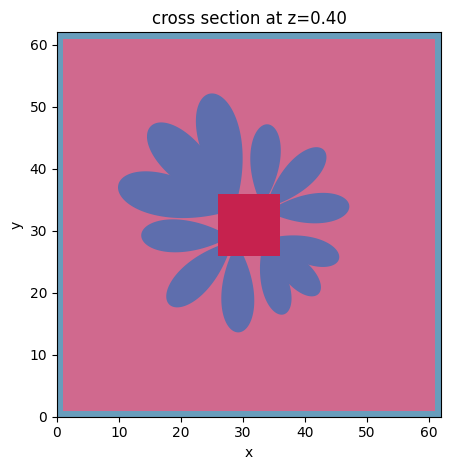

In [ ]:
fans = generate_petal_fan_list(solution[0])
print(solution[0][15])
fan_structure_list = []
fan_structure_list.append(fan_structure.generate_petal_fan(fans[0], solution[0][2], solution[0][3]))
i = 4
for z in range(1, 4):
    fan_structure_list[0] += fan_structure.generate_petal_fan(fans[z], solution[0][i+2], solution[0][i+3])
    i += 4

scene_planar1 = td.Scene(
       structures= [planar_vac]  + [planar_bottom_layer] + fan_structure_list[0] + [planar_top_layer]  + [planar_vac2],
         medium=background_medium,
     )

scene_planar1.plot(z=0.4)
plt.show()